우리는 어느정도 데이터분석을 통해 데이터 구조를 파악하였고 간단한 ML을 수행하였다.

이번에는 DL을 사용해서 다중 클래스 분류를 수행해보자.

In [1]:
# loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 

import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(os.listdir("./data"))

['LSWMD.pkl']


In [3]:
# Data summary
df=pd.read_pickle("./data/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df.shape

(811457, 6)

In [5]:
df = df.drop(['waferIndex'], axis = 1)
df.shape 

(811457, 5)

In [6]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
712304,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",516.0,lot43519,[[Test]],[[none]],"(25, 27)"
767905,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1376.0,lot45769,[[Test]],[[none]],"(44, 41)"
587760,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",515.0,lot36672,[],[],"(25, 27)"
590527,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2,...",515.0,lot36866,[],[],"(25, 27)"
20471,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",741.0,lot2481,[],[],"(33, 29)"


## 사이즈가 하나로 정해진 웨이퍼에 대한 모델링 수행하기 

해당 데이터에는 다양한 사이즈의 웨이퍼 정보가 들어있다.

이중 특정 사이즈의 웨이퍼에 대한 모델링을 수행한다.


In [7]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]      # waferMapDim가 (26,26)인 것만 뽑아서 
sub_wafer = sub_df['waferMap'].values               # 그것들의 웨에퍼 맵만 따로 뽑음 

In [8]:
sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):                        # 웨이퍼 맵 사이즈가 (26,26)인 것들 중에서 
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:   # failureType의 len이 0인 것, 즉 []인 빈값은 통과 
        continue
    
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))      # 쌓기위한 resizing
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [9]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [10]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


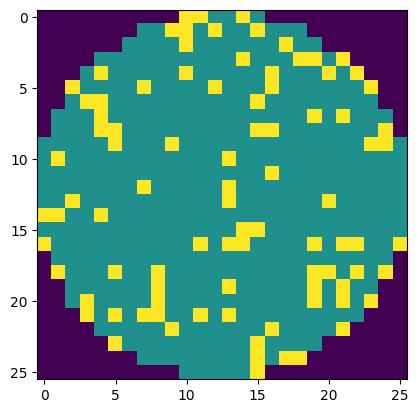

Faulty case : ['none'] 


In [11]:
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [12]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [13]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [14]:
#add channel
x = x.reshape((-1, 26, 26, 1))

In [15]:
x.shape

(14366, 26, 26, 1)

모든 행의 26x26 픽셀하나하나 돌면서 RGB 채널을 채워주자

In [16]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))       # x크기에 3채널인 빈 이미지 

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [17]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)